# 1. 数据集生成
首先，我们创建一个虚拟的时间序列数据集，其中包含正常的数据以及异常的数据点。

接下来，我们会使用一个神经网络模型来检测这些异常点，并利用Attention机制来增强模型的表现。

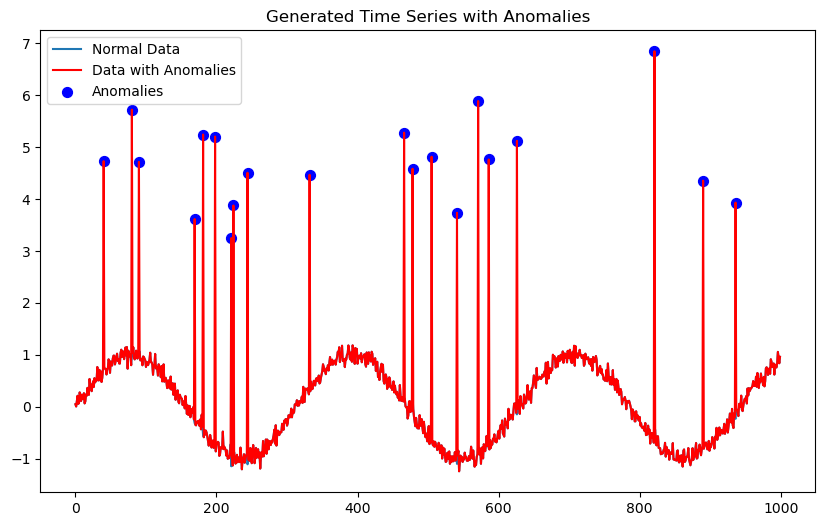

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以确保结果可重复
np.random.seed(42)

# 生成时间序列数据
time = np.arange(0, 1000, 1)
normal_data = np.sin(0.02 * time) + np.random.normal(0, 0.1, len(time))
anomaly_data = normal_data.copy()

# 在随机位置插入异常值
anomaly_indices = np.random.choice(len(time), size=20, replace=False)
anomaly_data[anomaly_indices] += np.random.normal(5, 1, len(anomaly_indices))

# 数据存储为 DataFrame
df = pd.DataFrame({
    'time': time,
    'value': anomaly_data,
    'normal_value': normal_data
})

# 绘制生成的时间序列数据
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['normal_value'], label='Normal Data')
plt.plot(df['time'], df['value'], label='Data with Anomalies', color='red')
plt.scatter(df['time'][anomaly_indices], df['value'][anomaly_indices], color='blue', label='Anomalies', s=50)
plt.title('Generated Time Series with Anomalies')
plt.legend()
plt.show()


# 2. 构建LSTM-Attention模型

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset



# 超参数设置
"""
input_size = 1
hidden_size = 64
attention_size = 32
num_layers = 1
"""

# 定义LSTM模型，加入Attention机制
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 64, attention_size = 32, num_layers =1 ):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, attention_size)
        self.attention_combine = nn.Linear(attention_size, 1)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # LSTM输出
        lstm_out, _ = self.lstm(x)
        
        # 计算Attention权重
        attention_weights = torch.tanh(self.attention(lstm_out))
        attention_weights = torch.softmax(self.attention_combine(attention_weights), dim=1)
        
        # 通过Attention加权LSTM输出
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)
        
        # 通过全连接层预测
        output = self.fc(attended_output)
        return output

# 定义虚拟数据集
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.data[idx:idx + self.window_size]),
            torch.FloatTensor([self.data[idx + self.window_size]])
        )



In [ ]:
# 超参数设置
input_size = 1
hidden_size = 64
attention_size = 32
num_layers = 1
window_size = 30
batch_size = 32
epochs = 50
# 处理数据
data = df['value'].values
dataset = TimeSeriesDataset(data, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 模型初始化
model = LSTMAttentionModel(input_size, hidden_size, attention_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 模型训练

In [ ]:

# 模型训练过程
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.unsqueeze(-1)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}')

# 用训练好的模型检测异常
model.eval()
predicted = []
for i in range(len(df) - window_size):
    input_data = torch.FloatTensor(df['value'][i:i + window_size].values).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        predicted.append(model(input_data).item())

# 结果可视化
df['predicted'] = np.nan
df.loc[window_size:, 'predicted'] = predicted


Epoch 1/50, Loss: 0.5295326020568609
Epoch 2/50, Loss: 0.5614556449074899
Epoch 3/50, Loss: 0.5278889530248219
Epoch 4/50, Loss: 0.5288265453831803
Epoch 5/50, Loss: 0.5274801981304923
Epoch 6/50, Loss: 0.5625417465644498
Epoch 7/50, Loss: 0.5324954599622758
Epoch 8/50, Loss: 0.5275395642966032
Epoch 9/50, Loss: 0.6423267750369925
Epoch 10/50, Loss: 0.5342933160643424
Epoch 11/50, Loss: 0.5289184237499872
Epoch 12/50, Loss: 0.5263006352489034
Epoch 13/50, Loss: 0.5930399240985993
Epoch 14/50, Loss: 0.5275310088670061
Epoch 15/50, Loss: 0.5260920362967637
Epoch 16/50, Loss: 0.5260970758935136
Epoch 17/50, Loss: 0.5263504148611138
Epoch 18/50, Loss: 0.5242428013514127
Epoch 19/50, Loss: 0.5304004210498063
Epoch 20/50, Loss: 0.525870970780811
Epoch 21/50, Loss: 0.5922746015412192
Epoch 22/50, Loss: 0.5260621391597294
Epoch 23/50, Loss: 0.5281174357439722
Epoch 24/50, Loss: 0.5276153705293133
Epoch 25/50, Loss: 0.5229915851546872
Epoch 26/50, Loss: 0.5240283248525474
Epoch 27/50, Loss: 0.5

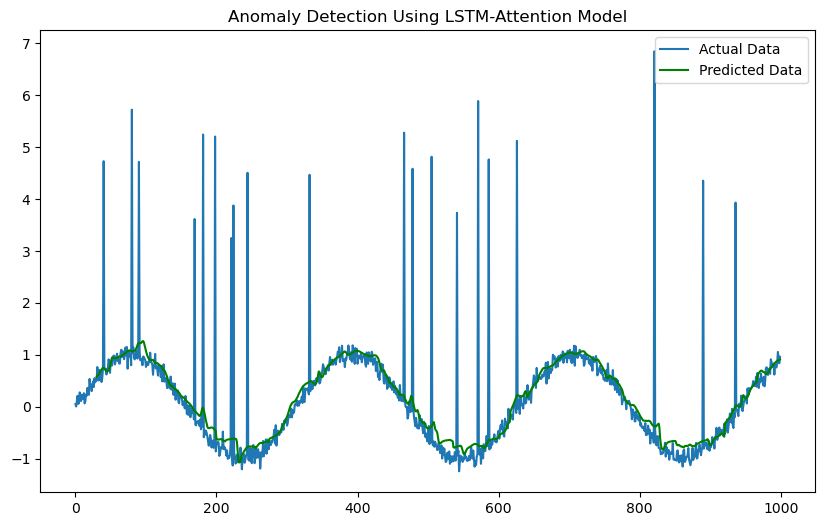

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['value'], label='Actual Data')
plt.plot(df['time'], df['predicted'], label='Predicted Data', color='green')
plt.title('Anomaly Detection Using LSTM-Attention Model')
plt.legend()
plt.show()

In [ ]:
a